# Trabajo Práctico Final - Aprendizaje de Máquina I (AmMaqI) CEIA

#### Autores: 
- Rivollier, Gaspar

## Introducción 

El presente trabajo práctico tiene como objetivo desarrollar un modelo predictivo capaz de estimar el riesgo relativo de ocurrencia de delitos en función de variables espaciales y temporales. Para ello, se basa en el [dataset de delitos del gobierno de la Ciudad de Buenos Aires](https://data.buenosaires.gob.ar/dataset/delitos), sobre el cual se aplicaron técnicas de modelado supervisado utilizando XGBoost como algoritmo principal.

El enfoque busca capturar patrones espacio-temporales en la distribución delictiva, evaluando el impacto de variables como el día de la semana, el mes y la franja horaria sobre la probabilidad de ocurrencia. Una vez entrenado el modelo, se generaron mapas de calor por hora del día, permitiendo visualizar la dinámica geográfica del riesgo en distintos momentos.

El desempeño del modelo fue evaluado mediante métricas como RMSE, MAE y R², alcanzando un nivel de precisión satisfactorio y demostrando la capacidad del enfoque para asistir en tareas de análisis predictivo y toma de decisiones basadas en datos.

### Descripción del dataset

El dataset contiene información georreferenciada sobre los **hechos delictivos registrados en la Ciudad Autónoma de Buenos Aires (CABA)**, recopilados por el **Ministerio de Justicia y Seguridad del Gobierno de la Ciudad** y publicados en el portal oficial [Buenos Aires Data](https://data.buenosaires.gob.ar/).

---

##### 🧱 Estructura general

- **Formato:** CSV (valores separados por coma)
- **Período cubierto:** 2016 en adelante
- **Frecuencia de actualización:** anual
- **Cantidad de columnas:** 15
- **Unidad de análisis:** cada fila representa un hecho delictivo individual, geolocalizado y clasificado según su tipo penal

---

##### 🧩 Principales variables

| Columna | Tipo | Descripción |
|----------|------|-------------|
| `id-mapa` | int64 | Identificador único del hecho |
| `anio` | int64 | Año del suceso |
| `mes` | string | Mes del hecho (texto, ej. “ENERO”) |
| `dia` | string | Día de la semana del hecho |
| `fecha` | date | Fecha exacta del hecho (YYYY-MM-DD) |
| `franja` | float | Franja horaria o hora estimada (0–24) |
| `tipo` | string | Tipo general de delito (Robo, Hurto, Lesiones, etc.) |
| `subtipo` | string | Subcategoría del tipo de delito |
| `uso_arma` | string | Indica si hubo utilización de arma de fuego o arma blanca |
| `uso_moto` | string | Indica si el hecho involucró el uso de motocicleta |
| `barrio` | string | Barrio de la Ciudad donde ocurrió el hecho |
| `comuna` | int64 | Comuna correspondiente |
| `latitud` | float | Coordenada geográfica de latitud |
| `longitud` | float | Coordenada geográfica de longitud |
| `cantidad` | int | Cantidad de hechos (normalmente 1) |

## Configuraciones e Imports

In [ ]:
# =====================
# Configuración & Imports

# --- Utilidades del sistema y tiempo ---
import os
import math
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta

# --- Ciencia de datos y visualización ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Modelado y evaluación ---
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV, 
    TimeSeriesSplit
)
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    FunctionTransformer, 
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    root_mean_squared_error
)
from sklearn.inspection import permutation_importance

# --- Modelos avanzados ---
from xgboost import XGBRegressor, plot_importance
from scipy.stats import randint, uniform

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Data import

In [ ]:
# Bloque de deteccion de colab/local para montar drive y definir path
# Detect environment (Colab vs local)
try:
    import google.colab  # Try to import Colab module
    IN_COLAB = True
except ImportError:
    IN_COLAB = False


# Mount drive if in Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = "/content/drive/MyDrive/CEIA/25-B4 ApMq/TP/Dataset"
else:
    # Local path (adjust if needed)
    DATA_DIR = os.path.join(os.getcwd(), "dataset")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Detecta automáticamente todos los archivos .csv dentro de la carpeta
csv_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".csv")]
print(f"Se encontraron {len(csv_files)} archivos CSV.")

# Carga y concatena todos los CSV
df_list = []
for path in csv_files:
    try:
        df = pd.read_csv(path)
        df_list.append(df)
        print(f"✔️  {os.path.basename(path)} ({len(df)} filas)")
    except Exception as e:
        print(f"⚠️ Error con {os.path.basename(path)}: {e}")

df = pd.concat(df_list, ignore_index=True)
print("\nTotal filas combinadas:", len(df))

df.head()


Se encontraron 9 archivos CSV.
✔️  delitos_2016.csv (154712 filas)
✔️  delitos_2017.csv (146938 filas)
✔️  delitos_2018.csv (149455 filas)
✔️  delitos_2020.csv (86175 filas)
✔️  delitos_2021.csv (111962 filas)
✔️  delitos_2019.csv (149524 filas)
✔️  delitos_2022.csv (140918 filas)
✔️  delitos_2023.csv (155897 filas)
✔️  delitos_2024.csv (158838 filas)

Total filas combinadas: 1254419


,id-mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,latitud,longitud,cantidad
0,500001,2016,ENERO,MARTES,2016-01-26,21.0,Robo,Robo total,NO,NO,VILLA REAL,10.0,-34.617668,-58.530961,1
1,500004,2016,ENERO,MIERCOLES,2016-01-20,16.0,Robo,Robo total,NO,NO,VILLA REAL,10.0,-34.620262,-58.530738,1
2,500007,2016,ENERO,DOMINGO,2016-01-03,13.0,Robo,Robo total,SI,NO,LINIERS,9.0,-34.640094,-58.529826,1
3,500010,2016,ENERO,SABADO,2016-01-09,17.0,Robo,Robo total,NO,NO,LINIERS,9.0,-34.640094,-58.529826,1
4,500013,2016,ENERO,LUNES,2016-01-25,18.0,Robo,Robo total,NO,NO,LINIERS,9.0,-34.640094,-58.529826,1


## Exploratory Data Analysis

In [ ]:
# Ajuste del dataset
# Aseguramos que la columna 'fecha' sea datetime
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Conteo de delitos por día
df['_date'] = df['fecha'].dt.date
counts_by_day = df.groupby('_date').size()

In [ ]:

# Estructura general
print("Dimensiones del dataset:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

# Nulos y valores únicos
print("\nCantidad de valores nulos por columna:")
print(df.isna().sum().sort_values(ascending=False))

Dimensiones del dataset: (1254419, 16)

Tipos de datos:
id-mapa              int64
anio                 int64
mes                 object
dia                 object
fecha       datetime64[ns]
franja             float64
tipo                object
subtipo             object
uso_arma            object
uso_moto            object
barrio              object
comuna             float64
latitud            float64
longitud           float64
cantidad             int64
_date               object
dtype: object

Cantidad de valores nulos por columna:
comuna      31983
barrio      31981
latitud     27721
longitud    27721
franja       2375
id-mapa         0
mes             0
anio            0
subtipo         0
tipo            0
fecha           0
dia             0
uso_arma        0
uso_moto        0
cantidad        0
_date           0
dtype: int64


In [40]:
print("\nCantidad de valores únicos por columna:")
print(df.nunique().sort_values(ascending=False))

# Porcentaje de nulos
null_percent = df.isna().mean().sort_values(ascending=False) * 100
print("\nPorcentaje de nulos (%):")
print(null_percent)


Cantidad de valores únicos por columna:
id-mapa     1254419
longitud     315976
latitud      295783
fecha          3288
_date          3288
barrio           48
franja           24
comuna           15
mes              12
subtipo          10
anio              9
dia               7
tipo              6
uso_moto          2
uso_arma          2
cantidad          1
dtype: int64

Porcentaje de nulos (%):
comuna      2.549627
barrio      2.549467
latitud     2.209868
longitud    2.209868
franja      0.189331
id-mapa     0.000000
mes         0.000000
anio        0.000000
subtipo     0.000000
tipo        0.000000
fecha       0.000000
dia         0.000000
uso_arma    0.000000
uso_moto    0.000000
cantidad    0.000000
_date       0.000000
dtype: float64


In [41]:
# Vemos poco impacto porcentual en el dataset. Continuamos con la remoción de los nulos
print("shape df original:", df.shape)
print("shape sin NaNs:", df.dropna().shape)

df.dropna(inplace=True)

shape df original: (1254419, 16)
shape sin NaNs: (1220378, 16)


In [42]:
df.head(5)

,id-mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,latitud,longitud,cantidad,_date
0,500001,2016,ENERO,MARTES,2016-01-26,21.0,Robo,Robo total,NO,NO,VILLA REAL,10.0,-34.617668,-58.530961,1,2016-01-26
1,500004,2016,ENERO,MIERCOLES,2016-01-20,16.0,Robo,Robo total,NO,NO,VILLA REAL,10.0,-34.620262,-58.530738,1,2016-01-20
2,500007,2016,ENERO,DOMINGO,2016-01-03,13.0,Robo,Robo total,SI,NO,LINIERS,9.0,-34.640094,-58.529826,1,2016-01-03
3,500010,2016,ENERO,SABADO,2016-01-09,17.0,Robo,Robo total,NO,NO,LINIERS,9.0,-34.640094,-58.529826,1,2016-01-09
4,500013,2016,ENERO,LUNES,2016-01-25,18.0,Robo,Robo total,NO,NO,LINIERS,9.0,-34.640094,-58.529826,1,2016-01-25


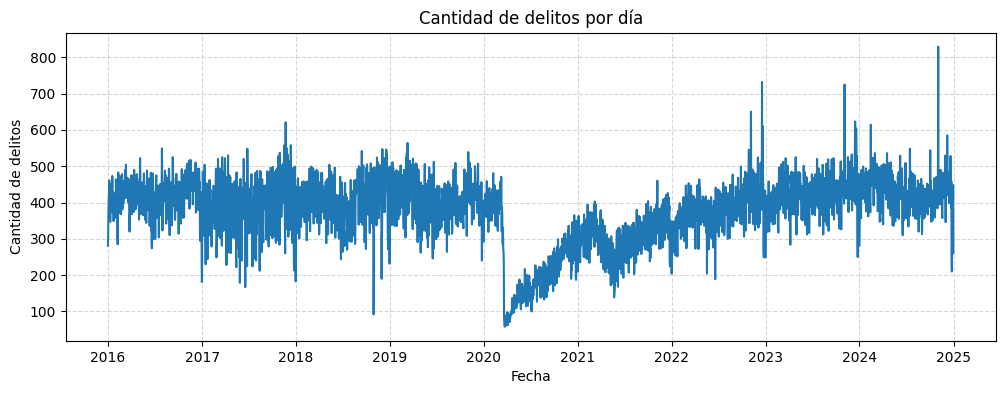

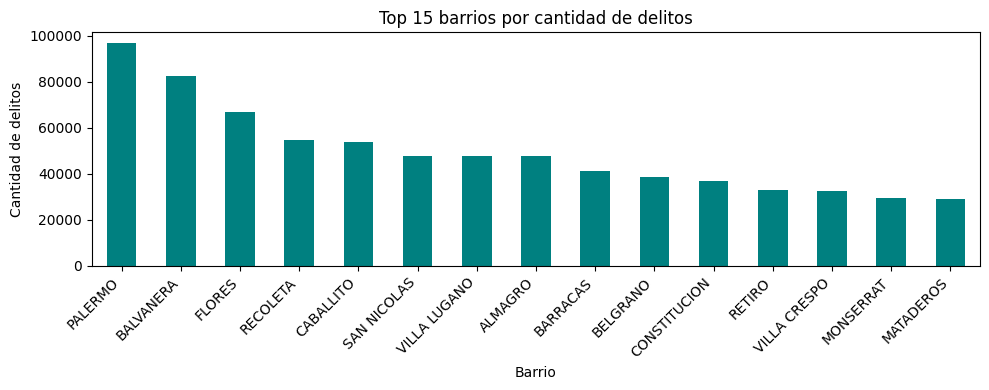

Se detectó columna de tipo de delito: tipo


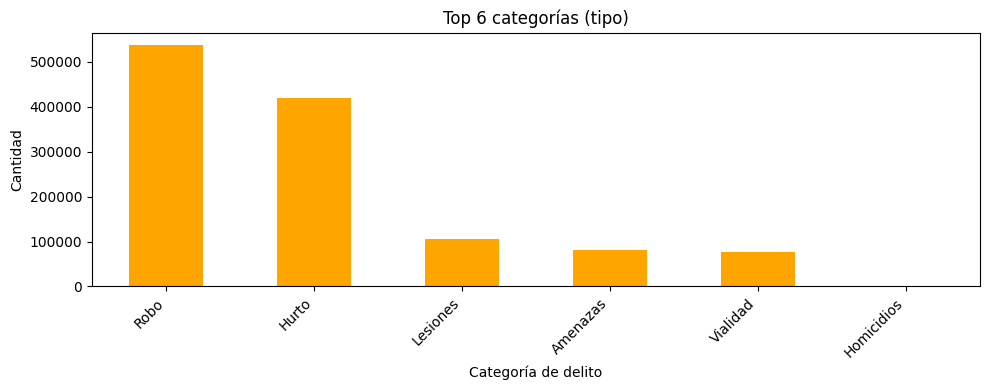

In [43]:

plt.figure(figsize=(12, 4))
counts_by_day.plot()
plt.title("Cantidad de delitos por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de delitos")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Top barrios
# Verificamos que exista una columna válida
if 'barrio' in df.columns:
    geo_col = 'barrio'
elif 'comuna' in df.columns:
    geo_col = 'comuna'
else:
    raise ValueError("No se encontró columna geográfica válida ('barrio' o 'comuna').")

top_geo = df[geo_col].value_counts().head(15)

plt.figure(figsize=(10, 4))
top_geo.plot(kind='bar', color='teal')
plt.title(f"Top {len(top_geo)} {geo_col}s por cantidad de delitos")
plt.xlabel(geo_col.capitalize())
plt.ylabel("Cantidad de delitos")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Tipo de delito
guess_type_cols = [c for c in df.columns if 'delito' in c or 'hecho' in c or 'tipo' in c]

if guess_type_cols:
    tipo_col = guess_type_cols[0]
    print(f"Se detectó columna de tipo de delito: {tipo_col}")
    top_tipo = df[tipo_col].value_counts().head(15)
    plt.figure(figsize=(10, 4))
    top_tipo.plot(kind='bar', color='orange')
    plt.title(f"Top {len(top_tipo)} categorías ({tipo_col})")
    plt.xlabel("Categoría de delito")
    plt.ylabel("Cantidad")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Las estadísticas de 2020 están muy por debajo del promedio. Muy posiblemente por la pandemia COVID-19. Se decide retirar del análisis todo 2020 y 2021 porque se quiere analizar la posibilidad de delitos en condiciones normales. En este análisis tomamos períodos normales hasta 2020 y desde 2022.

In [44]:
# Filtramos años 2020 y 2021
df['anio'] = df['anio'].astype(int)
df = df[~df['anio'].isin([2020, 2021])]
# Recalcular los conteos por fecha usando el DataFrame filtrado
counts_by_day = df.groupby('fecha').size()


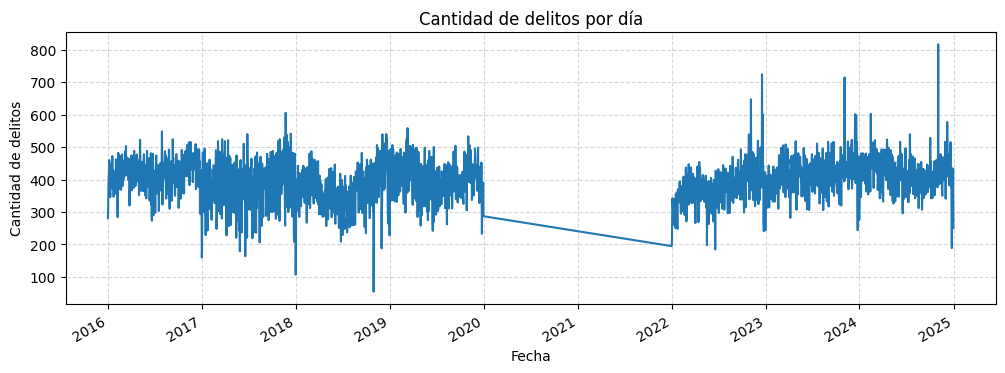

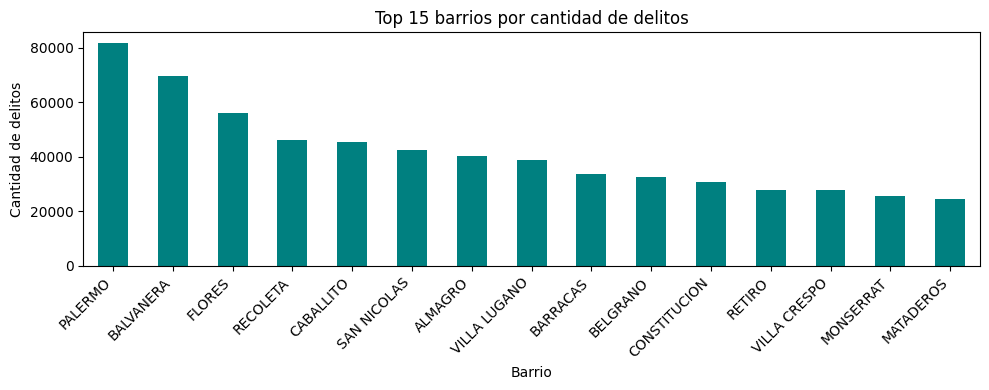

Se detectó columna de tipo de delito: tipo


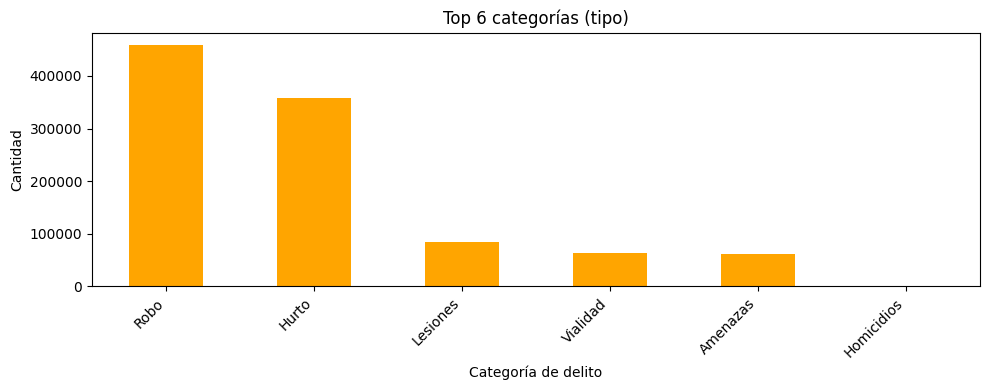

In [45]:
# --- Gráfico de delitos por día ---
plt.figure(figsize=(12, 4))
counts_by_day.plot()
plt.title("Cantidad de delitos por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de delitos")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Top barrios o comunas ---
if 'barrio' in df.columns:
    geo_col = 'barrio'
elif 'comuna' in df.columns:
    geo_col = 'comuna'
else:
    raise ValueError("No se encontró columna geográfica válida ('barrio' o 'comuna').")

top_geo = df[geo_col].value_counts().head(15)

plt.figure(figsize=(10, 4))
top_geo.plot(kind='bar', color='teal')
plt.title(f"Top {len(top_geo)} {geo_col}s por cantidad de delitos")
plt.xlabel(geo_col.capitalize())
plt.ylabel("Cantidad de delitos")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Tipo de delito ---
guess_type_cols = [c for c in df.columns if 'delito' in c or 'hecho' in c or 'tipo' in c]

if guess_type_cols:
    tipo_col = guess_type_cols[0]
    print(f"Se detectó columna de tipo de delito: {tipo_col}")
    top_tipo = df[tipo_col].value_counts().head(15)
    plt.figure(figsize=(10, 4))
    top_tipo.plot(kind='bar', color='orange')
    plt.title(f"Top {len(top_tipo)} categorías ({tipo_col})")
    plt.xlabel("Categoría de delito")
    plt.ylabel("Cantidad")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## Pre-processing

In [46]:
# Dropeamos id-mapa, _date, comuna (vamos a usar barrio), año (solo usamos dia, mes y numero de dia)
df.drop(columns=['id-mapa', '_date', 'comuna', 'anio'], inplace=True, errors='ignore')
df.head(5)

,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,latitud,longitud,cantidad
0,ENERO,MARTES,2016-01-26,21.0,Robo,Robo total,NO,NO,VILLA REAL,-34.617668,-58.530961,1
1,ENERO,MIERCOLES,2016-01-20,16.0,Robo,Robo total,NO,NO,VILLA REAL,-34.620262,-58.530738,1
2,ENERO,DOMINGO,2016-01-03,13.0,Robo,Robo total,SI,NO,LINIERS,-34.640094,-58.529826,1
3,ENERO,SABADO,2016-01-09,17.0,Robo,Robo total,NO,NO,LINIERS,-34.640094,-58.529826,1
4,ENERO,LUNES,2016-01-25,18.0,Robo,Robo total,NO,NO,LINIERS,-34.640094,-58.529826,1


In [47]:
# Convertir fecha a día del mes,
df['dia_num'] = df['fecha'].dt.day
df.drop(columns=['fecha'], errors='ignore')
df.head(5)

,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,latitud,longitud,cantidad,dia_num
0,ENERO,MARTES,2016-01-26,21.0,Robo,Robo total,NO,NO,VILLA REAL,-34.617668,-58.530961,1,26
1,ENERO,MIERCOLES,2016-01-20,16.0,Robo,Robo total,NO,NO,VILLA REAL,-34.620262,-58.530738,1,20
2,ENERO,DOMINGO,2016-01-03,13.0,Robo,Robo total,SI,NO,LINIERS,-34.640094,-58.529826,1,3
3,ENERO,SABADO,2016-01-09,17.0,Robo,Robo total,NO,NO,LINIERS,-34.640094,-58.529826,1,9
4,ENERO,LUNES,2016-01-25,18.0,Robo,Robo total,NO,NO,LINIERS,-34.640094,-58.529826,1,25


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


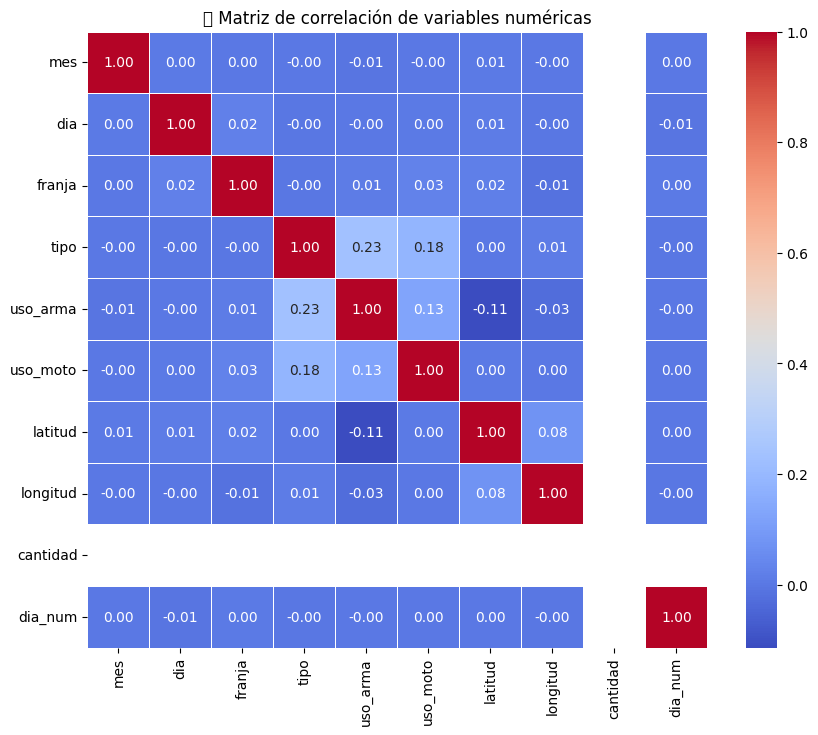

In [48]:
# Convertimos variables categóricas relevantes a numéricas
df_corr = df.copy()

# Encode simple para variables categóricas
for col in ['dia', 'mes', 'uso_arma', 'uso_moto', 'tipo']:
    df_corr[col] = df_corr[col].astype('category').cat.codes

# Calculamos matriz de correlación
corr = df_corr.corr(numeric_only=True)

# Graficamos el mapa de calor
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("📊 Matriz de correlación de variables numéricas")
plt.show()


Las variables mas correlacionadas parecen ser tipo con uso_arma, y uso_moto con tipo (0.23 y 0.18 respectivamente). Proseguimos con las variables seleccionadas.

Para poder generar predicciones, debo generar bins de longitud, latitud y agruparlos por dia, dia_num, mes, franja. Para que luego se pueda trabajar la regresion.

In [49]:
# Definimos el tamaño de cada celda (ajustable)
lat_bin_size = 0.5
lon_bin_size = 0.5

# Creamos columnas de bin espacial
df['lat_bin'] = (df['latitud'] // lat_bin_size) * lat_bin_size
df['lon_bin'] = (df['longitud'] // lon_bin_size) * lon_bin_size


In [50]:
df_grouped = (
    df.groupby(['dia', 'dia_num', 'mes', 'franja', 'lat_bin', 'lon_bin'])
      .agg({'cantidad':'sum'})
      .reset_index()
)

df_grouped.sort_values('cantidad', ascending=False).head(5)


,dia,dia_num,mes,franja,lat_bin,lon_bin,cantidad
47569,SABADO,2,NOVIEMBRE,0.0,-35.0,-58.5,308
19071,LUNES,2,DICIEMBRE,0.0,-35.0,-58.5,284
43,DOMINGO,1,DICIEMBRE,0.0,-35.0,-58.5,283
48863,SABADO,7,DICIEMBRE,0.0,-35.0,-58.5,267
58910,VIERNES,8,NOVIEMBRE,0.0,-35.0,-58.5,266


In [51]:
df_grouped.shape

(65893, 7)

In [52]:
# Convertimos variables categóricas simples en códigos numéricos
for col in ['dia', 'mes']:
    df_grouped[col] = df_grouped[col].astype('category').cat.codes

## Entrenamiento preliminar de modelos y comparación

### Splitting dataset

In [ ]:

X = df_grouped[['lat_bin', 'lon_bin', 'dia_num', 'franja', 'dia', 'mes']]
y = df_grouped['cantidad']

# 4️⃣ Train-test split + escalado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Modelo baseline (regresión)

RMSE: 10.618
MAE:  7.357
R²:   0.562


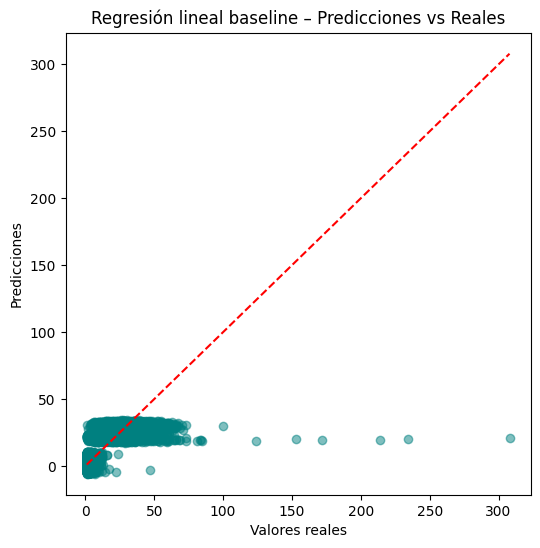

In [54]:
# Seteo de modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Evaluación
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")

# Visualización
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Regresión lineal baseline – Predicciones vs Reales")
plt.show()

### Random Forest

Random Forest -> RMSE: 9.304
                  MAE:  5.326
                  R²:   0.664


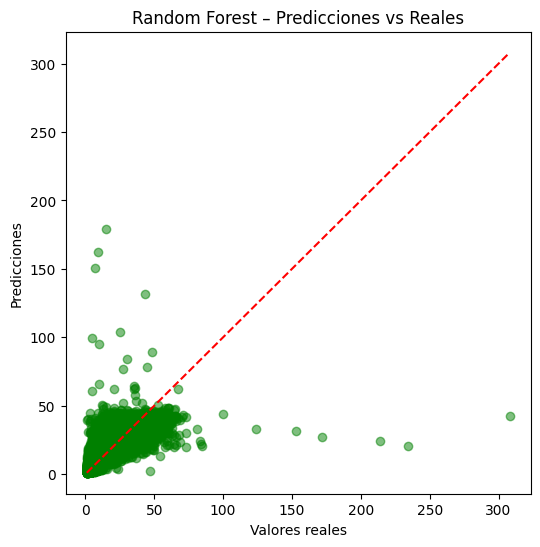

In [55]:
# Modelo
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
# Entrenamiento
rf_model.fit(X_train, y_train)
# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluación
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest -> RMSE: {rmse_rf:.3f}")
print(f"                  MAE:  {mae_rf:.3f}")
print(f"                  R²:   {r2_rf:.3f}")

# Visualización
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Random Forest – Predicciones vs Reales")
plt.show()


### Modelo XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost -> RMSE: 8.859
            MAE:  5.140
            R²:   0.695


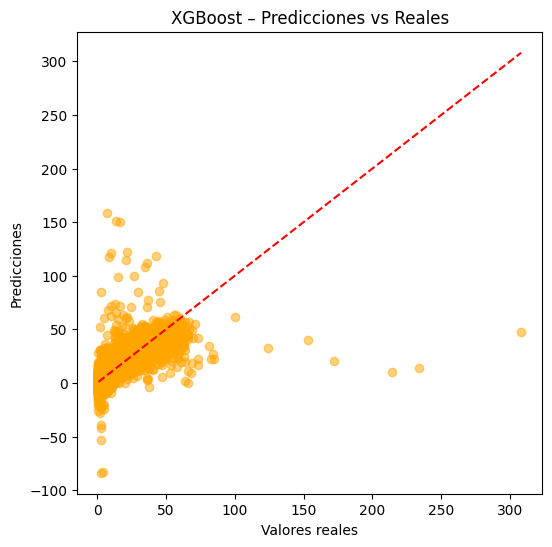

In [56]:
# Modelo
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=15,
    subsample=0.8,
    colsample_bytree=0.8,
    device = "cuda",   # usa GPU si está disponible
    predictor='gpu_predictor',
    random_state=42,
    n_jobs=-1
)
# Entrenamiento
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluación
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost -> RMSE: {rmse_xgb:.3f}")
print(f"            MAE:  {mae_xgb:.3f}")
print(f"            R²:   {r2_xgb:.3f}")

# Visualización
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("XGBoost – Predicciones vs Reales")
plt.show()


## Comparación preliminar de modelos


,Modelo,RMSE,MAE,R²
0,XGBoost,8.859173,5.140144,0.695051
1,Random Forest,9.304496,5.325617,0.663623
2,Regresión Lineal,10.618035,7.357198,0.561945


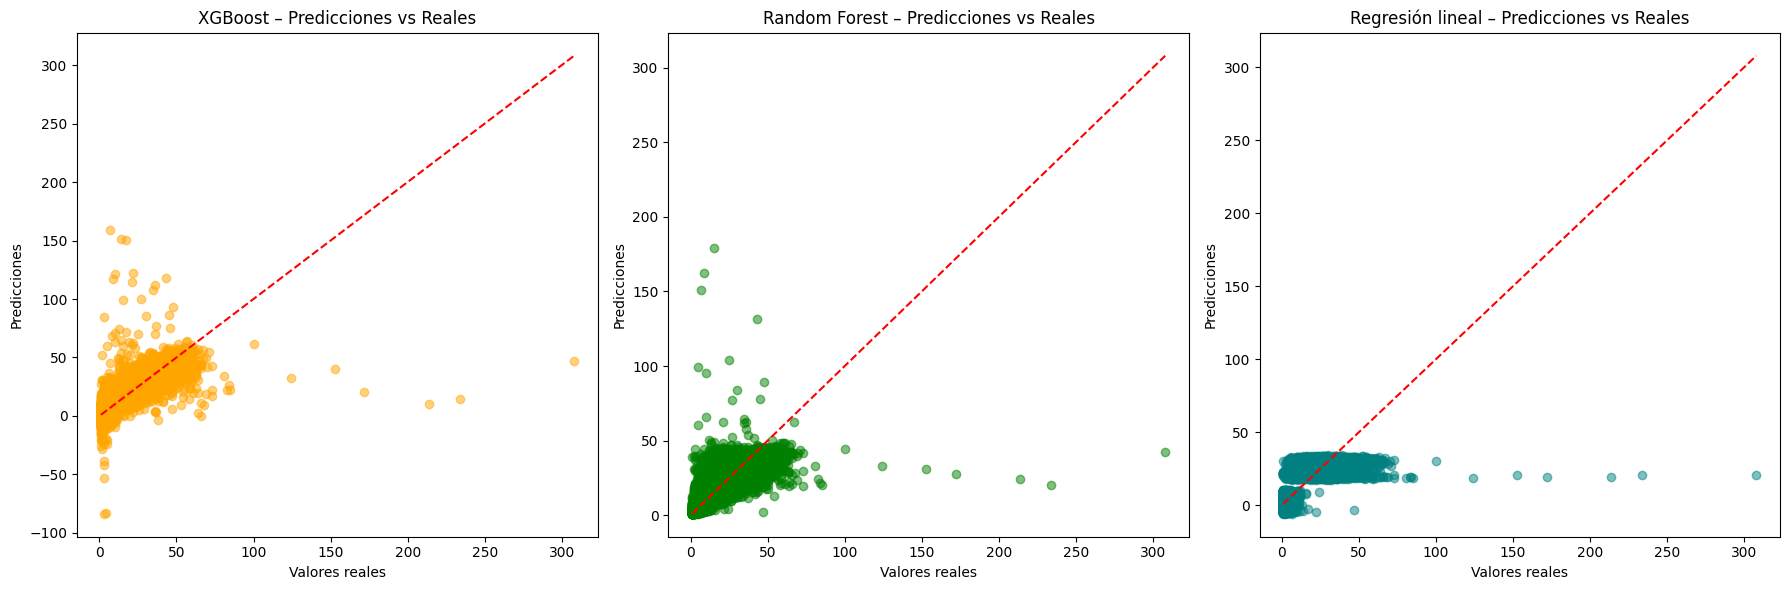

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

#  Tabla comparativa de métricas
results = pd.DataFrame({
    'Modelo': ['XGBoost', 'Random Forest', 'Regresión Lineal'],
    'RMSE': [rmse_xgb, rmse_rf, rmse],
    'MAE': [mae_xgb, mae_rf, mae],
    'R²': [r2_xgb, r2_rf, r2]
})

# Mostrar tabla ordenada por R² descendente
results = results.sort_values(by='R²', ascending=False).reset_index(drop=True)
display(results)

# --- Visualización comparativa de predicciones ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# XGBoost
axes[0].scatter(y_test, y_pred_xgb, alpha=0.5, color='orange')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title("XGBoost – Predicciones vs Reales")
axes[0].set_xlabel("Valores reales")
axes[0].set_ylabel("Predicciones")

# Random Forest
axes[1].scatter(y_test, y_pred_rf, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_title("Random Forest – Predicciones vs Reales")
axes[1].set_xlabel("Valores reales")
axes[1].set_ylabel("Predicciones")

# Regresión lineal
axes[2].scatter(y_test, y_pred, alpha=0.5, color='teal')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[2].set_title("Regresión lineal – Predicciones vs Reales")
axes[2].set_xlabel("Valores reales")
axes[2].set_ylabel("Predicciones")

plt.tight_layout()
plt.show()


Podemos ver que XGBoost esta algo por encima del resto de modelos. Continuamos con una búsqueda de hiperparametros para lograr el mejor resultado posible del modelo.

## Entrenamiento de XGBoost

### Búsqueda de hiperparámetros

In [ ]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuración base GPU
xgb_gpu = XGBRegressor(
    tree_method='hist',            # eficiente para GPU
    predictor='gpu_predictor',     # usa GPU también para predicción
    device='cuda',                 # activa CUDA
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse',
    verbosity=1
)

# Espacio de búsqueda
param_dist = {
    'n_estimators': randint(400, 1200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(4, 15),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 1),
    'min_child_weight': randint(1, 10)
}


# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_gpu,
    param_distributions=param_dist,
    n_iter=30,              # aumentar si querés mejor ajuste
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento de búsqueda
print("⏳ Entrenando búsqueda aleatoria en GPU...")
random_search.fit(X_train, y_train)   # sin early stopping (incompatible con CV)

# Entrenamiento final con Early Stopping
print("\n✅ Mejores hiperparámetros encontrados:")
print(random_search.best_params_)
best_params=random_search.best_params_


⏳ Entrenando búsqueda aleatoria en GPU...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:59:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Mejores hiperparámetros encontrados:
{'colsample_bytree': np.float64(0.9265727492877536), 'gamma': np.float64(0.7983451249845511), 'learning_rate': np.float64(0.0401435087930859), 'max_depth': 14, 'min_child_weight': 6, 'n_estimators': 863, 'subsample': np.float64(0.6163100566219055)}


In [ ]:
import xgboost as xgb
import numpy as np

# 🔁 Recuperar variables clave para entrenamiento

# Crear matrices optimizadas de XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Construcción del diccionario de parámetros basado en best_params
params = {
    'tree_method': 'hist',     # usa hist con GPU moderno
    'device': 'cuda',          # GPU acceleration
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': float(best_params['learning_rate']),
    'max_depth': int(best_params['max_depth']),
    'subsample': float(best_params['subsample']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'gamma': float(best_params['gamma']),
    'min_child_weight': int(best_params['min_child_weight']),
    'seed': 42
}

# Número total de boosting rounds
num_boost_round = int(best_params['n_estimators'])

[0]	train-rmse:15.67791	test-rmse:15.60750
[50]	train-rmse:8.24735	test-rmse:8.96231
[100]	train-rmse:6.93384	test-rmse:8.26906
[150]	train-rmse:6.12924	test-rmse:7.86320
[200]	train-rmse:5.67585	test-rmse:7.74774
[250]	train-rmse:5.32208	test-rmse:7.64364
[300]	train-rmse:5.04247	test-rmse:7.60164
[350]	train-rmse:4.83224	test-rmse:7.62348
[351]	train-rmse:4.82456	test-rmse:7.62824


/tmp/ipython-input-1648918828.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


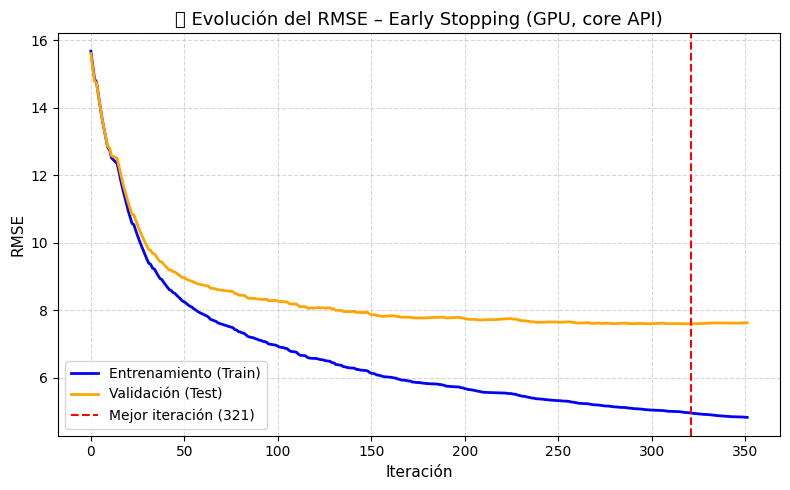


📊 Resultados finales:
XGBoost Tuned (GPU) → RMSE: 7.628
                        MAE:  4.180
                        R²:   0.774


In [ ]:

#  Curva de RMSE
# Volvemos a ejecutar el entrenamiento para capturar el evals_result manualmente
evals_result = {}
evals = [(dtrain, 'train'), (dtest, 'test')]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=50,
    evals_result=evals_result   # ✅ guardamos el historial explícitamente
)

# Extraemos RMSE del diccionario
train_rmse = evals_result['train']['rmse']
test_rmse = evals_result['test']['rmse']

plt.figure(figsize=(8,5))
plt.plot(train_rmse, label='Entrenamiento (Train)', color='blue', linewidth=2)
plt.plot(test_rmse, label='Validación (Test)', color='orange', linewidth=2)
plt.axvline(model.best_iteration, color='red', linestyle='--',
            label=f'Mejor iteración ({model.best_iteration})')
plt.xlabel("Iteración", fontsize=11)
plt.ylabel("RMSE", fontsize=11)
plt.title("📊 Evolución del RMSE – Early Stopping (GPU, core API)", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Evaluación final
y_pred_xgb_tuned = model.predict(dtest)

rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned))
mae_xgb_tuned = mean_absolute_error(y_test, y_pred_xgb_tuned)
r2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)

print("\n Resultados finales:")
print(f"XGBoost Tuned (GPU) → RMSE: {rmse_xgb_tuned:.3f}")
print(f"                        MAE:  {mae_xgb_tuned:.3f}")
print(f"                        R²:   {r2_xgb_tuned:.3f}")


,Modelo,RMSE,MAE,R²
0,XGBoost Tuned (GPU),7.628243,4.179704,0.773906
1,XGBoost,8.859173,5.140144,0.695051
2,Random Forest,9.304496,5.325617,0.663623
3,Regresión Lineal,10.618035,7.357198,0.561945


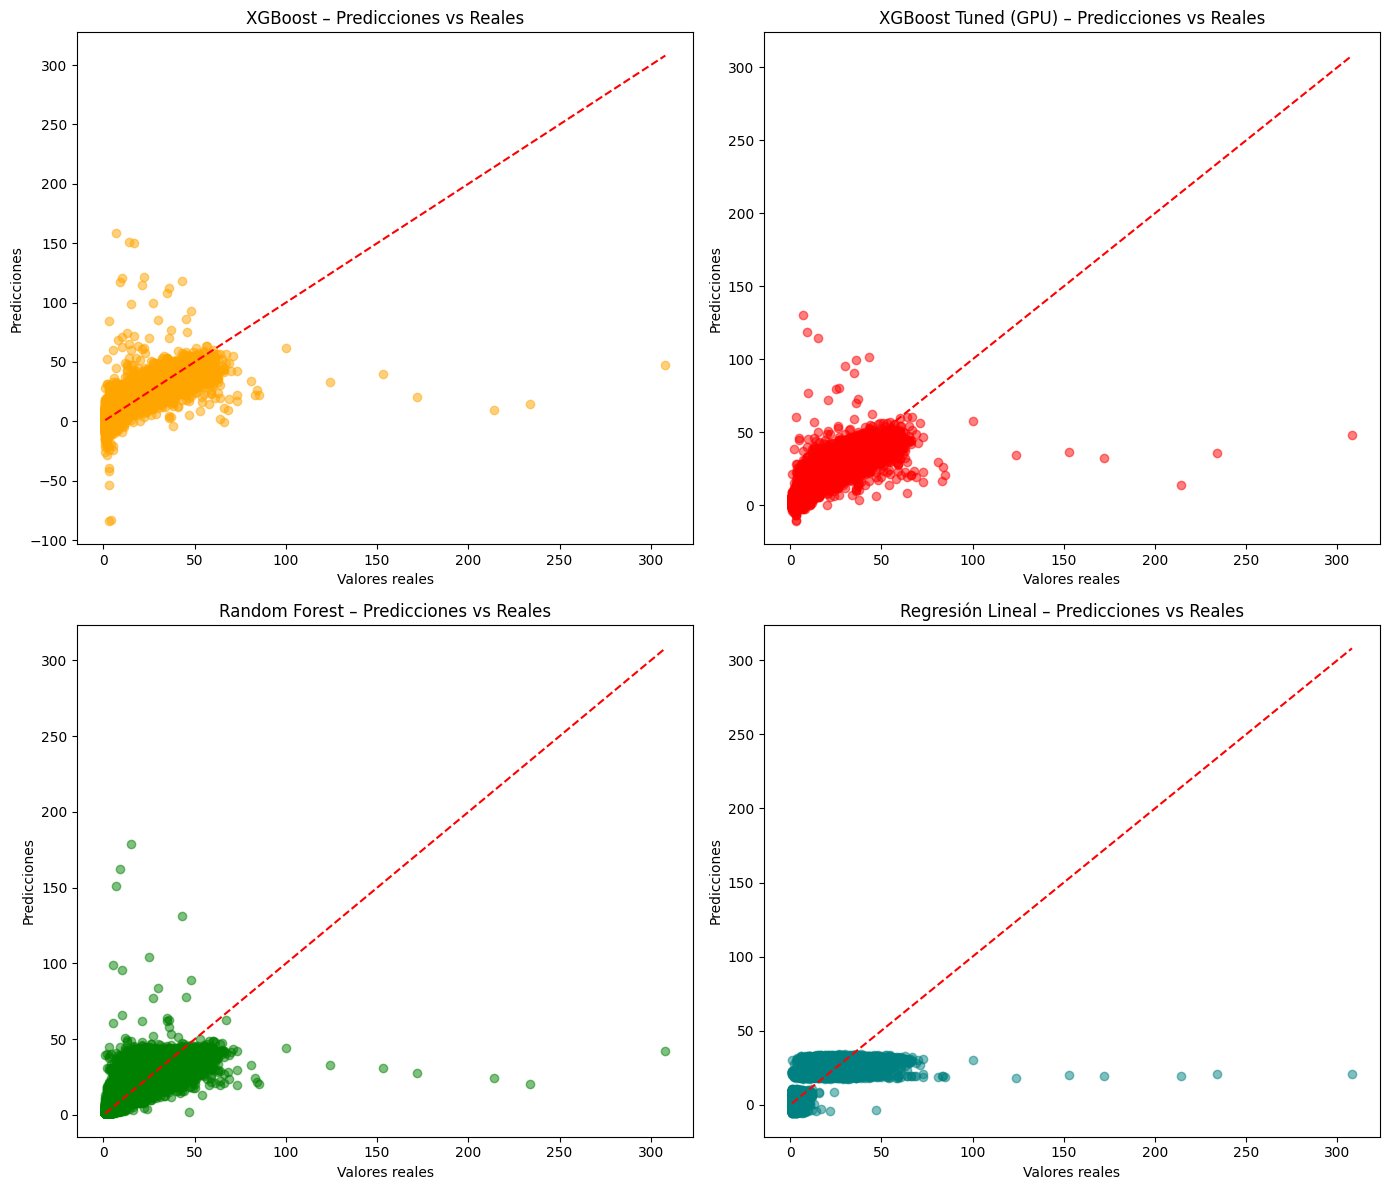

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Tabla comparativa de métricas
results = pd.DataFrame({
    'Modelo': ['XGBoost', 'XGBoost Tuned (GPU)', 'Random Forest', 'Regresión Lineal'],
    'RMSE': [rmse_xgb, rmse_xgb_tuned, rmse_rf, rmse],  # 🔹 ajustá rmse si tu XGBoost Tuned tiene otra variable (rmse_tuned)
    'MAE': [mae_xgb, mae_xgb_tuned, mae_rf, mae],       # idem para mae_tuned
    'R²': [r2_xgb, r2_xgb_tuned, r2_rf, r2]             # idem para r2_tuned
})

# Si guardaste métricas del modelo tuned con otras variables, actualizá así:
# 'RMSE': [rmse_xgb, rmse_tuned, rmse_rf, rmse],
# 'MAE': [mae_xgb, mae_tuned, mae_rf, mae],
# 'R²': [r2_xgb, r2_tuned, r2_rf, r2],

# Ordenar por R² descendente
results = results.sort_values(by='R²', ascending=False).reset_index(drop=True)
display(results)


# Visualización comparativa de predicciones
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# --- XGBoost base ---
axes[0,0].scatter(y_test, y_pred_xgb, alpha=0.5, color='orange')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,0].set_title("XGBoost – Predicciones vs Reales")
axes[0,0].set_xlabel("Valores reales")
axes[0,0].set_ylabel("Predicciones")

# --- XGBoost Tuned (GPU) ---
axes[0,1].scatter(y_test, y_pred_xgb_tuned, alpha=0.5, color='red')  # si guardaste y_pred_tuned, usalo aquí
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,1].set_title("XGBoost Tuned (GPU) – Predicciones vs Reales")
axes[0,1].set_xlabel("Valores reales")
axes[0,1].set_ylabel("Predicciones")

# --- Random Forest ---
axes[1,0].scatter(y_test, y_pred_rf, alpha=0.5, color='green')
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1,0].set_title("Random Forest – Predicciones vs Reales")
axes[1,0].set_xlabel("Valores reales")
axes[1,0].set_ylabel("Predicciones")

# --- Regresión Lineal ---
axes[1,1].scatter(y_test, y_pred, alpha=0.5, color='teal')
axes[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1,1].set_title("Regresión Lineal – Predicciones vs Reales")
axes[1,1].set_xlabel("Valores reales")
axes[1,1].set_ylabel("Predicciones")

plt.tight_layout()
plt.show()


analisis de resultados

## Visualizacion y utilización del modelo

In [30]:
df_pred = df.copy()

# Aseguramos tener las mismas columnas que en el entrenamiento
for col in X_train.columns:
    if col not in df_pred.columns:
        df_pred[col] = X_train[col].mean()  # relleno seguro

# Convertimos columnas de texto a categorías numéricas
for col in df_pred.select_dtypes(include='object').columns:
    df_pred[col] = df_pred[col].astype('category').cat.codes

# También igualamos el orden y tipo
df_pred = df_pred[X_train.columns].astype(float, errors='ignore')

# Ahora sí creamos el DMatrix
dmat = xgb.DMatrix(df_pred)
df_pred['riesgo'] = model.predict(dmat)

# Normalizamos el riesgo
df_pred['riesgo_norm'] = (
    df_pred['riesgo'] - df_pred['riesgo'].min()
) / (df_pred['riesgo'].max() - df_pred['riesgo'].min())


In [ ]:

# Verificamos nombres de columnas geográficas
import re

# Buscamos columnas candidatas
cols = df_pred.columns
lat_col = next((c for c in cols if re.search('lat', c, re.IGNORECASE)), None)
lon_col = next((c for c in cols if re.search('lon|long', c, re.IGNORECASE)), None)

if not lat_col or not lon_col:
    raise ValueError("No se encontraron columnas de latitud/longitud en el DataFrame.")

# Renombramos de forma estándar
df_pred = df_pred.rename(columns={lat_col: 'latitud', lon_col: 'longitud'})

print(f"✅ Usando columnas: latitud='{lat_col}', longitud='{lon_col}'")


✅ Usando columnas: latitud='lat_bin', longitud='lon_bin'


In [32]:
import numpy as np
import pandas as pd
import xgboost as xgb
import re

# --- Dataset base ---
df_pred = df.copy()

# 🧭 Detectamos columnas de coordenadas
cols = df_pred.columns
lat_col = next((c for c in cols if re.search('lat', c, re.IGNORECASE)), None)
lon_col = next((c for c in cols if re.search('lon|long', c, re.IGNORECASE)), None)

if not lat_col or not lon_col:
    raise ValueError("No se encontraron columnas de latitud/longitud en el DataFrame.")

# --- Reproducimos el binning EXACTO del entrenamiento ---
lat_bin_size = 0.5
lon_bin_size = 0.5

df_pred['lat_bin'] = (df_pred[lat_col] // lat_bin_size) * lat_bin_size
df_pred['lon_bin'] = (df_pred[lon_col] // lon_bin_size) * lon_bin_size

# --- Aseguramos columnas consistentes ---
for col in X_train.columns:
    if col not in df_pred.columns:
        df_pred[col] = 0

# --- Convertimos textos a códigos numéricos ---
for col in df_pred.select_dtypes(include='object').columns:
    df_pred[col] = df_pred[col].astype('category').cat.codes

# --- Reordenamos y convertimos a float ---
df_pred = df_pred[X_train.columns].astype(float)

# --- Predicciones ---
dmat = xgb.DMatrix(df_pred)
df_pred['riesgo'] = model.predict(dmat)

# --- Normalización ---
df_pred['riesgo_norm'] = (
    df_pred['riesgo'] - df_pred['riesgo'].min()
) / (df_pred['riesgo'].max() - df_pred['riesgo'].min())

print("✅ Predicciones generadas y normalizadas correctamente.")


✅ Predicciones generadas y normalizadas correctamente.


/tmp/ipython-input-4061601836.py:87: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


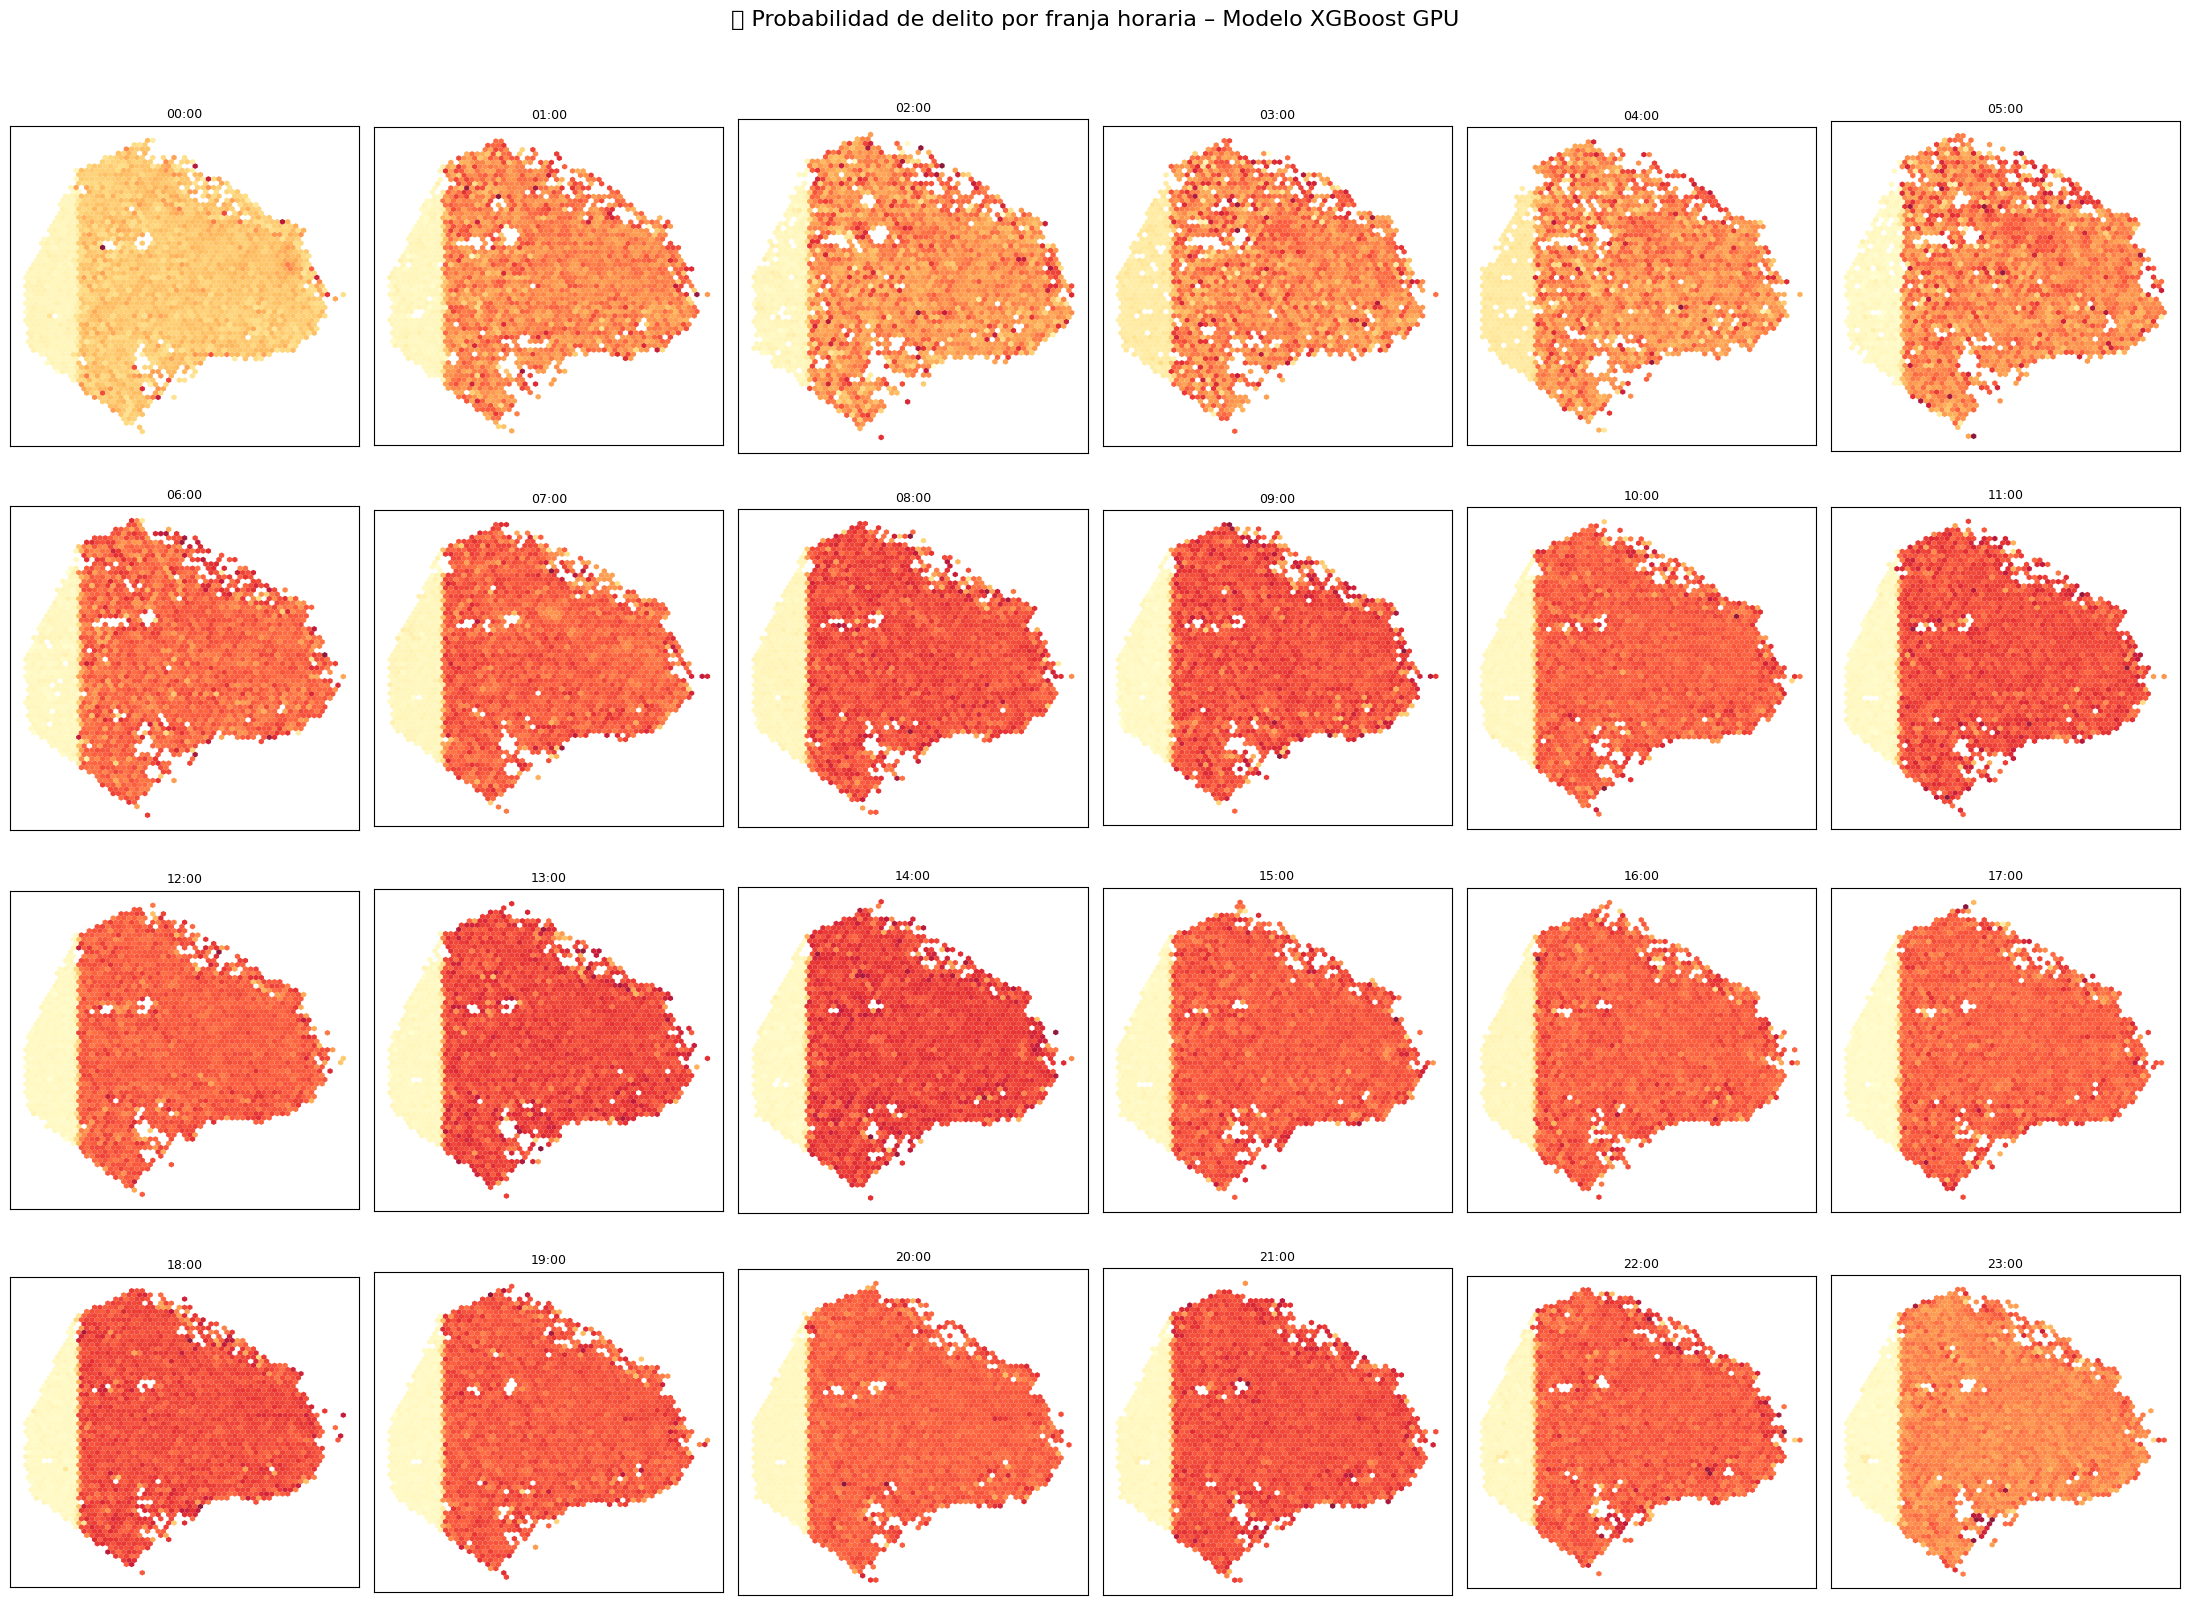

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import re

# Preparación del dataset
df_pred = df.copy()

# Guardamos las columnas que necesitamos para graficar
geo_cols = ['latitud', 'longitud', 'franja']
for c in geo_cols:
    if c not in df_pred.columns:
        raise ValueError(f"Falta columna requerida: {c}")

# Detectamos columnas geográficas
cols = df_pred.columns
lat_col = next((c for c in cols if re.search('lat', c, re.IGNORECASE)), None)
lon_col = next((c for c in cols if re.search('lon|long', c, re.IGNORECASE)), None)

# --- Reproducimos el binning EXACTO del entrenamiento ---
lat_bin_size = 0.5
lon_bin_size = 0.5
df_pred['lat_bin'] = (df_pred[lat_col] // lat_bin_size) * lat_bin_size
df_pred['lon_bin'] = (df_pred[lon_col] // lon_bin_size) * lon_bin_size

# Predicción de riesgo
# Creamos copia solo con columnas del modelo
df_model = df_pred.copy()

# Aseguramos columnas consistentes con X_train
for col in X_train.columns:
    if col not in df_model.columns:
        df_model[col] = 0

# Convertimos texto a códigos numéricos
for col in df_model.select_dtypes(include='object').columns:
    df_model[col] = df_model[col].astype('category').cat.codes

# Reordenamos y convertimos a float
df_model = df_model[X_train.columns].astype(float)

# Generamos predicciones
dmat = xgb.DMatrix(df_model)
df_pred['riesgo'] = model.predict(dmat)

# Normalización a rango [0,1]
df_pred['riesgo_norm'] = (
    df_pred['riesgo'] - df_pred['riesgo'].min()
) / (df_pred['riesgo'].max() - df_pred['riesgo'].min())
import matplotlib.pyplot as plt
import numpy as np

# --- Configuración general ---
fig, axes = plt.subplots(4, 6, figsize=(22, 16))
axes = axes.flatten()

for i, franja in enumerate(sorted(df_pred['franja'].unique())[:24]):
    ax = axes[i]
    subset = df_pred[df_pred['franja'] == franja]

    if len(subset) > 0:
        hb = ax.hexbin(
            subset['longitud'],
            subset['latitud'],
            C=subset['riesgo_norm'],
            gridsize=60,       # controla resolución del mapa
            cmap='YlOrRd',
            reduce_C_function=np.mean,
            linewidths=0.0,
            alpha=0.9
        )
    ax.set_title(f"{int(franja):02d}:00", fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.set_aspect('equal')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle("🗺️ Probabilidad de delito por franja horaria – Modelo XGBoost GPU", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
